In [1]:
using GenericLinearAlgebra
using LinearAlgebra
using SpecialFunctions
using Dates
using PolynomialRoots
using MAT
using Printf
using FFTW
using StatsBase
using JLD2
using Random
using Plots
using StatsPlots
using LaTeXStrings
using Distributions
using Distributed

In [3]:
using IJulia
IJulia.installkernel("Julia 12 Threads", env=Dict(
    "JULIA_NUM_THREADS" => "12",
))

[ Info: Installing Julia 12 Threads kernelspec in C:\Users\keepw\AppData\Roaming\jupyter\kernels\julia-12-threads-1.8


"C:\\Users\\keepw\\AppData\\Roaming\\jupyter\\kernels\\julia-12-threads-1.8"

In [2]:
Threads.nthreads()

12

want to generate the code via just manually tracking the qsp matrices
how? you have some list \sum ck z^k and multiply by either pk z (so that its \sum pk ck z^k+1) or qk z-1 (so that its \sum qk ck z^k - 1) and then align the z coefficients and add up

then, given this long matrix, feed it into the haah qsp subroutine and see what it spits out. 

## Constants

In [4]:
# constants: pauli matrices

# set type of matrix to be Complex{BigFloat}

setprecision(BigFloat, 2048)

const SX = Complex{BigFloat}[0 1; 1 0]
const SY = Complex{BigFloat}[0 -im; im 0]
const SZ = Complex{BigFloat}[1 0; 0 -1]
const SI = Complex{BigFloat}[1 0; 0 1]
const H = Complex{BigFloat}[1 1; 1 -1] / sqrt(2)
const S = Complex{BigFloat}[1 0; 0 im]

function SumSigmaVec(sigmavec)
    return sigmavec[1]*SX + sigmavec[2]*SY + sigmavec[3]*SZ
end

SumSigmaVec (generic function with 1 method)

## Haah codes / Perfect setting

In [5]:
function BigFloatFFT(x)
    # Perform FFT on vector x
    # This function only works for length(x) = 2^k
    N = length(x);
    xp = x[1:2:end];
    xpp = x[2:2:end];
    if(N>=8)
        Xp = BigFloatFFT(xp);
        Xpp = BigFloatFFT(xpp);
        X = zeros(Complex{BigFloat},N,1);
        Wn = exp.(big.(-2)im*big.(pi)*(big.(0:N/2-1))/big.(N));
        tmp = Wn .* Xpp;
        X = [(Xp + tmp);(Xp -tmp)];
    elseif(N==2)
        X = big.([1 1;1 -1])*x;
    elseif(N==4)
        X = big.([1 0 1 0; 0 1 0 -1im; 1 0 -1 0;0 1 0 1im]*[1 0 1 0;1 0 -1 0;0 1 0 1;0 1 0 -1])*x;
    end
    return X
end

function getarg(x)
    # Obtain the angle of a complex number
    x = x/abs(x)
    xr = acos(real(x))
    xi = asin(imag(x))
    if(xi>0)
        if(xr>0)
            return xr-2*pi
        else
            return xr
        end
    else
        return -xr
    end
end 
function getQSPvalue(P,t)
    # Given P_j (0\le j \le n), yield <+|E_0...E_{n}|+>, where E_j(t)=tP_j+(I-P_j)/t
    eig_x = Complex{BigFloat}[1;1]/sqrt(big.(2))
    init = copy(eig_x)
    for i=1:size(P)[3]-1
        init = init/t+(t-big.(1)/t)*P[:,:,end+1-i]*init
    end
    return eig_x'*P[:,:,1]*init
end

getQSPvalue (generic function with 1 method)

In [6]:
function ProduceCns(PhiList)
    """
    Given a list of L Phi angles, reconstruct the L + 1 C_n matrices
    """
    # our function is e^i theta * PhiList.Sigma
    # the eigenvectors correspond to the eigenvectors of PhiList.Sigma
    # (we need to assume the rows of PhiList.Sigma have norm 1)
    # note that PhiList.Sigma = P - Q, I = P + Q,
    # so P = (PhiList.Sigma + I)/2, Q = (I - PhiList.Sigma)/2

    # performing the rotations 
    # r_\phi_L r_\phi_L-1 ... r_\phi_1

    L = length(PhiList)

    # this ranges from 0:-L to L:L, strided by 2
    # Cns = zeros(Complex{BigFloat}, 2, 2, 2 * L + 1)
    Cns = zeros(Complex{BigFloat}, 2, 2, L + 1)

    Cns[:, :, 1] = SI

    for k = 1:L
        # newCns = zeros(Complex{BigFloat}, 2, 2, 2 * L + 1)
        newCns = zeros(Complex{BigFloat}, 2, 2, L + 1)

        # we will apply each rotation
        # first, get the zP + z^-1 Q form
        pminusq = SumSigmaVec(PhiList[k])
        zk = (SI + pminusq) / 2
        qk = (SI - pminusq) / 2

        # assert
        # complex0 = Complex{BigFloat}(0)
        # @assert(Cns[1, 1, L + 1] == Complex{BigFloat}(0))

        newCns[:, :, 1] = qk * Cns[:, :, 1]
        for j = 2: L
            newCns[:, :, j] = zk * Cns[:, :, j - 1] + qk * Cns[:, :, j] 
        end
        newCns[:, :, L + 1] = zk * Cns[:, :, L]

        Cns = newCns
    end
    return Cns
end

ProduceCns (generic function with 1 method)

In [7]:
# perform FFT on each component

function HaahInvert(C; GSLW_out = true, stop_eps=1e-10, get_axis=false)
            
    # C = zeros(Complex{BigFloat},2,2,2*degree_n+1)
    # C_11 = BigFloatFFT(avalue_list+im*dvalue_list)
    # C_12 = BigFloatFFT(cvalue_list+im*bvalue_list)
    # C_21 = BigFloatFFT(-cvalue_list+im*bvalue_list)
    # C_22 = BigFloatFFT(avalue_list-im*dvalue_list)
    # C[1,1,:] = [C_11[D-degree_n+1:D];C_11[1:degree_n+1]]/big.(D)
    # C[1,2,:] = [C_12[D-degree_n+1:D];C_12[1:degree_n+1]]/big.(D)
    # C[2,1,:] = [C_21[D-degree_n+1:D];C_21[1:degree_n+1]]/big.(D)
    # C[2,2,:] = [C_22[D-degree_n+1:D];C_22[1:degree_n+1]]/big.(D)

    # Step 5: From matrix C, caluculate the projection matrix P (and thus our objective E)
    # degree_n = (length(C[1,1,:])-1) ÷ 2
    degree_n = length(C[1,1,:])-1
    R = 2048

    zeta_A = real(C[1, 1, :])
    zeta_B = complex(C[1, 1, :])
    degree_N = length(zeta_A) # the true degree of A is in fact degree_N-1
    p_A = length(zeta_A)%2
    p_B = length(zeta_B)%2
    

    while(true)
        # C = C[:,:,1:2:end]
        setprecision(BigFloat, R)
        
        if get_axis
            axis = zeros(Float64, degree_N, 3)
        end
        phi = zeros(Float64,degree_n+1)
        P = zeros(Complex{BigFloat},2,2,degree_n+1)

        for i=1:degree_n
            tmp_P = C[:,:,end]'*C[:,:,end]
            tmp_Q = C[:,:,1]'*C[:,:,1]
            P_i = tmp_P/tr(tmp_P)
            Q_i = tmp_Q/tr(tmp_Q)
            P[:,:,degree_n+2-i] = P_i
            # phi[degree_n+2-i] = getarg(P[1,2,degree_n+2-i])
            # compute axis using my method
            phi[degree_n+2-i] = getarg(P[1,2,degree_n+2-i])
            if get_axis
                axis[degree_n+2-i, :] = 2 * [real(P[1,2,degree_n+2-i]), -imag(P[1,2,degree_n+2-i]), 0]
            end

            C_new = zeros(Complex{BigFloat},2,2,degree_n+1-i)
            for j=1:degree_n+1-i
                C_new[:,:,j] = C[:,:,j]*Q_i+C[:,:,j+1]*P_i
            end
            C = copy(C_new)
        end
        P[:,:,1] = copy(C[:,:,1])
        phi[1] = getarg(P[1,1,1])
        if get_axis
            return axis
        end
        return phi
    end
end

HaahInvert (generic function with 1 method)

In [8]:
### TEST HAAH CODES
# cosine of pi

# random list of angles
errors = 0

for _ = 1:100
    N = 20
    philist = [rand() * 2 * pi for j = 1:N]
    philist3 = [[cos(phi) sin(phi) 0] for phi in philist] 

    # cns = ProduceCns(philist3)
    # perturbation = 1e-18
    # cns[:, :, :] = cns[:, :, :] + perturbation * rand(Complex{BigFloat}, 2, 2, N + 1)
    # inverted_phi = HaahInvert(cns)

    inverted_phi = HaahInvert(ProduceCns(philist3))
    inverted_phi = -1 * inverted_phi[N + 1:-1:2]

    println(maximum(abs.(philist - inverted_phi)))
    if maximum(abs.(philist - inverted_phi)) > 1e-10
        println("Error")
        println(maximum(philist - inverted_phi))
        errors = errors + 1
    end
end

8.881784197001252e-16
4.440892098500626e-16
8.881784197001252e-16
3.1086244689504383e-15
1.7763568394002505e-15
2.6645352591003757e-15
1.7763568394002505e-15
3.552713678800501e-15
8.881784197001252e-16
1.7763568394002505e-15
4.440892098500626e-15
4.440892098500626e-16
8.881784197001252e-16
8.881784197001252e-16
8.881784197001252e-16
8.881784197001252e-16
2.7755575615628914e-15
7.993605777301127e-15
6.217248937900877e-15
3.952393967665557e-14
8.881784197001252e-16
1.7763568394002505e-15
8.881784197001252e-16
1.887379141862766e-15
9.992007221626409e-16
2.220446049250313e-15
8.881784197001252e-16
4.440892098500626e-16
8.881784197001252e-16
7.105427357601002e-15
2.6645352591003757e-15
1.7763568394002505e-15
1.1546319456101628e-14
1.1546319456101628e-14
8.881784197001252e-15
4.440892098500626e-16
1.7763568394002505e-14
1.7763568394002505e-15
1.3322676295501878e-15
8.881784197001252e-16
8.881784197001252e-16
1.7763568394002505e-15
3.3306690738754696e-15
8.881784197001252e-16
2.66453525910037

In [9]:
rand(Binomial(100, 0.5))

52

## Tomography / error code

In [10]:
function single_qubit_state_tomography(psi; M=Inf, spam_error=0)
    # Returns alpha, beta such that |psi> = alpha |0> + beta |1> 
    # Get the x, y, z expectation values
    if psi isa Vector
        x = real(psi' * SX * psi)
        y = real(psi' * SY * psi)
        z = real(psi' * SZ * psi)
    else
        x = real(tr(SX * psi))
        y = real(tr(SY * psi))
        z = real(tr(SZ * psi))
    end

    if spam_error > 0
        # we need to adjust the distributions via a confusion matrix
        # in particular:
        # 1 - t01     t10 
        # t01     1 - t10
        # assume symmetry for now
        # so, we have that p0 -> p0 * (1 - t01) + (1 - p0) * t01 
        t01 = spam_error  
        ps = ([x y z] .+ 1.) ./ 2.0
        ps = ps .* (1 - t01) + (1 .- ps) .* t01

        x, y, z = (ps .* 2) .- 1
    end

    # avoid numerics issues
    x = clamp(x, -1, 1)
    y = clamp(y, -1, 1)
    z = clamp(z, -1, 1)

    if M != Inf
        # Sample with binomial distribution
        px = Binomial(M, (convert(Float64, x) + 1) / 2)
        py = Binomial(M, (convert(Float64, y) + 1) / 2)
        pz = Binomial(M, (convert(Float64, z) + 1) / 2)

        x = 2 * (rand(px) / M) - 1
        y = 2 * (rand(py) / M) - 1
        z = 2 * (rand(pz) / M) - 1
    end

    # TODO: perform a perturbation by a delta amount here; apply confusion matrix, symmetric
    # TODO: done, I believe

    # Compute alpha, beta values
    alpha = real(sqrt(clamp((1 + z) / 2, 0., 1.)))
    alphabeta = (x + im * y) / 2

    if alpha == 0
        beta = 1
    else
        beta = alphabeta / alpha
    end

    # Renormalize if necessary
    total_norm = sqrt(abs(alpha)^2 + abs(beta)^2)
    alpha /= total_norm
    beta /= total_norm

    @assert abs(abs(alpha)^2 + abs(beta)^2 - 1) < 1e-4

    return alpha, beta
end

single_qubit_state_tomography (generic function with 1 method)

In [11]:
function gather_data(U; M=inf, spam_error=0)
    alpha_ad, beta_cb_ad = single_qubit_state_tomography(U * Complex{BigFloat}[1; 0], M=M, spam_error=spam_error)
    alpha_ab, beta_cd_ab = single_qubit_state_tomography(H * U * H * Complex{BigFloat}[1; 0], M=M, spam_error=spam_error)
    
    # Make the |+i> state with an S gate
    alpha_ac, beta_bd_ac = single_qubit_state_tomography(H * S' * U * S * H * Complex{BigFloat}[1; 0], M=M, spam_error=spam_error)

    return [alpha_ab alpha_ac alpha_ad], [beta_cb_ad beta_cd_ab beta_bd_ac]
end

function gather_data_dm(channel; M=inf, spam_error=0)
    rho0 = Complex{BigFloat}[1 0; 0 0]
    rhoplus = H * rho0 * H
    rhoplusi = S * rhoplus * S'

    alpha_ad, beta_cb_ad = single_qubit_state_tomography(channel(rho0), M=M, spam_error=spam_error)
    alpha_ab, beta_cd_ab = single_qubit_state_tomography(H * channel(rhoplus) * H, M=M, spam_error=spam_error)
    
    # Make the |+i> state with an S gate
    alpha_ac, beta_bd_ac = single_qubit_state_tomography(H * S' * channel(rhoplusi) * S * H, M=M, spam_error=spam_error)

    return [alpha_ab alpha_ac alpha_ad], [beta_cb_ad beta_cd_ab beta_bd_ac]
end

function postprocess_data(alpha_ab, alpha_ac, alpha_ad)
    # postprocess measurement data to find initial magnitudes
    absq = alpha_ab^2
    acsq = alpha_ac^2
    adsq = alpha_ad^2

    # Estimate A, B, C, D's magnitudes
    abcd = absq + acsq + adsq
    A = sqrt(clamp((abcd - 1) / 2, 0., 1.))
    B = sqrt(clamp(absq - A^2, 0., 1.))
    C = sqrt(clamp(acsq - A^2, 0., 1.))
    D = sqrt(clamp(adsq - A^2, 0., 1.))

    # Rescale A, B, C, D if they are off
    out = [A B C D]
    out = out ./ sqrt(sum(out.^2))
    @assert abs(sum(out.^2) - 1) < 1e-4
    return out
end


postprocess_data (generic function with 1 method)

In [12]:
function single_qubit_unitary_tomography(U; DM=false, M=Inf, spam_error=0)
    # Perform magnitude and beta estimation
    if DM
        alphas, betas = gather_data_dm(U, M=M, spam_error=spam_error)
    else
        alphas, betas = gather_data(U, M=M, spam_error=spam_error)
    end
    
    alpha_ab, alpha_ac, alpha_ad = alphas
    beta_cb_ad, beta_cd_ab, beta_bd_ac = betas

    abcd_vals = postprocess_data(alpha_ab, alpha_ac, alpha_ad)

    # Estimate the signs of A, B, C, D by cross-checking with signs
    best_signs = [1 1 1 1]
    best_err = Inf

    for signs in Base.product(-1:2:1, -1:2:1, -1:2:1, -1:2:1)
        total_err = 0
        signs = [i for i in signs]'
        A, B, C, D = abcd_vals .* signs

        total_err += abs(beta_cb_ad - ((-C + im * B) / ((A + im * D) * abs(A + im * D))))
        total_err += abs(beta_cd_ab - ((C + im * D) / ((A + im * B) * abs(A + im * B))))
        total_err += abs(beta_bd_ac - ((-B + im * D) / ((A + im * C) * abs(A + im * C))))

        if total_err < best_err
            best_err = total_err
            best_signs = signs
        end
    end

    A, B, C, D = abcd_vals .* best_signs
    return A, B, C, D
end

single_qubit_unitary_tomography (generic function with 1 method)

In [13]:
# Test our tomography scheme
for _ in 1:100
    rand_coeffs = rand(4)
    rand_coeffs /= sqrt(sum(abs2.(rand_coeffs)))
    rand_U = rand_coeffs[1] * SI + rand_coeffs[2] * im * SX + rand_coeffs[3] * im * SY + rand_coeffs[4] * im * SZ

    println("Testing U = $rand_U")
    A, B, C, D = single_qubit_unitary_tomography(rand_U, spam_error=0, M=1000)

    pred_coeffs = [A, B, C, D]
    println("Min error: ", min(sum(abs2.(rand_coeffs - pred_coeffs)), sum(abs2.(rand_coeffs + pred_coeffs))))

    @assert findall(isnan, pred_coeffs) == []

    channelu(rho) = rand_U * rho * rand_U'
    Ad, Bd, Cd, Dd = single_qubit_unitary_tomography(channelu, DM=true)
    pred_coeffsd = [Ad, Bd, Cd, Dd]

    println("DM vs U sim: ", sum(abs2.(pred_coeffs - pred_coeffsd)))
    
    # @assert abs(sum(abs2.(pred_coeffs - pred_coeffsd))) < 1e-4
    # @assert abs(A^2 + B^2 + C^2 + D^2 - 1) < 1e-4

    Ase, Bse, Cse, Dse = single_qubit_unitary_tomography(rand_U, spam_error=1e-5)
    pred_coeffs_se = [Ase, Bse, Cse, Dse]
    println("SE error: ", min(sum(abs2.(rand_coeffs - pred_coeffs_se)), sum(abs2.(rand_coeffs + pred_coeffs_se))))
end


Testing U = Complex{BigFloat}[0.329750068561042219972279099238221533596515655517578125 + 0.56215579070704591035934072351665236055850982666015625im 0.1722757105525196397177722928972798399627208709716796875 + 0.73862496492614460041892243680194951593875885009765625im; -0.1722757105525196397177722928972798399627208709716796875 + 0.73862496492614460041892243680194951593875885009765625im 0.329750068561042219972279099238221533596515655517578125 - 0.56215579070704591035934072351665236055850982666015625im]
Min error: 0.003210954093228405
DM vs U sim: 0.003210954093228430563579617080977441316443471467513160680880056106913331419974437528703469076692230483922324169741845976216683223014378634699438710082491028007222491124128489447654553000046862849414533781530827477767476005214242066828882612825258198383208492102789972485884182547855134530230586123839595413223511514968782794929454896768572323091080018044112325031806727912891004929089235624698915649076359543028332667414722870277519620187712909384726

## Sampled code

In [14]:
# typically use P = nearest power of 2 of 2 * L + 1

function evaluate_unitary(phis, theta; global_phase = false)
    out_U = SI

    for phi in phis
        rx = cos(phi)
        ry = sin(phi)

        U = cos(theta) * SI + im * sin(theta) * (rx * SX + ry * SY)
        out_U = U * out_U
    end

    if global_phase
        return out_U * exp(im * theta * rand() * 2 * pi)
    end
    return out_U
end

function evaluate_channel(rho, phis, theta; spam_error=0, depolarizing = 0)
    for phi in phis
        rx = cos(phi)
        ry = sin(phi)

        U = cos(theta) * SI + im * sin(theta) * (rx * SX + ry * SY)
        rho = U * rho * U'

        if depolarizing > 0
            rho = (1 - depolarizing) * rho + depolarizing * SI / 2
        end
    end
    return rho
end

function get_U_at_point(phis, theta; global_phase = false, spam_error = 0, depolarizing = 0, M=Inf)
    # get the unitary at a specific point via tomography

    if depolarizing > 0
        # use dm simulation
        channel(rho) = evaluate_channel(rho, phis, theta, spam_error = spam_error, depolarizing = depolarizing)
        A, B, C, D = single_qubit_unitary_tomography(channel, DM=true, M=M,spam_error=spam_error)
    else 
        U = evaluate_unitary(phis, theta, global_phase = global_phase)
        A, B, C, D = single_qubit_unitary_tomography(U, M=M, spam_error=spam_error)
    end

    learned_U = A * SI + B * im * SX + C * im * SY + D * im * SZ

    if global_phase
        rand_sign = rand([-1, 1])
        return learned_U * rand_sign
    end
    return learned_U
end

function produce_cns_sampling(phis, P; M=Inf, global_phase=false, spam_error = 0, depolarizing = 0)
    # phis is a list of angles
    L = length(phis)

    # for theta in specific range, store all the sampled unitary values
    theta_range = range(0, stop=pi, length=P + 1)[1:end - 1]

    all_U = zeros(Complex{BigFloat}, 2, 2, 2 * P)

    for (i, theta) in enumerate(theta_range)
        U = get_U_at_point(phis, theta, global_phase = global_phase, spam_error = spam_error, depolarizing = depolarizing, M = M)
        U = U ./ sqrt(det(U))

        # sign corrections
        if i == 1
            prev = SI
        else
            prev = all_U[:, :, i - 1]
        end

        pos_dist = sum(abs.(prev - U))
        neg_dist = sum(abs.(prev + U))

        if pos_dist > neg_dist
            U = -U
        end

        all_U[:, :, i] = U
    end
    all_U[:, :, P + 1:end] = all_U[:, :, 1:P] * (-1)^L

    # then, apply FFT to extract the coefficients
    frequency = zeros(Complex{BigFloat}, 2, 2, 2 * P)
    frequency[1, 1, :] = BigFloatFFT(all_U[1, 1, :])
    frequency[1, 2, :] = BigFloatFFT(all_U[1, 2, :])
    frequency[2, 1, :] = BigFloatFFT(all_U[2, 1, :])
    frequency[2, 2, :] = BigFloatFFT(all_U[2, 2, :])
    
    # isolate the Cn components
    neg_freqs = frequency[:, :, end-L + 1:end]
    pos_freqs = frequency[:, :, 1:L + 1]
    cn = cat(neg_freqs, pos_freqs, dims=3)
    cn = cn[:, :, 1:2:end] / (2 * P)

    return cn
end

produce_cns_sampling (generic function with 1 method)

In [15]:
function angle_distance(angle1, angle2)
    return min(abs2(angle1 - angle2), abs2(2 * pi + angle1 - angle2))
end

angle_distance (generic function with 1 method)

In [16]:
L_TEST = 10
for _ in 1:100
    # test_angs = [BigFloat(rand()) for j = 1:L_TEST]
    test_angs = [BigFloat(rand()) for j = 1:L_TEST]
    # test_angs = [0 pi / 2]
    test_freq = produce_cns_sampling(test_angs, nextpow(2, length(test_angs) * 2 + 1), global_phase=true)
    # test_freq = ProduceCns([[cos(phi) sin(phi) 0] for phi in test_angs])

    # test_freq = produce_cns_sampling(test_angs, nextpow(2, length(test_angs) * 2 + 1), 10, global_phase=true, spam_error=1e-10)
    pred_angs = -1 * HaahInvert(test_freq, get_axis=false)[end:-1:2]
    # pred_axis = HaahInvert(test_freq, get_axis=true)[end:-1:2, :]

    # pred_angs = -1 * HaahInvert(true_freq)[end:-1:2]

    true_axis = reduce(vcat, [[cos(phi) sin(phi) 0] for phi in test_angs])

    println("Diff")
    meandiff = mean(angle_distance.(test_angs, pred_angs))
    # maxdiff = maximum(abs.(true_axis - pred_axis))
    println(meandiff)
    if meandiff > 1e-3
        println("Error")
        @assert false
    end
end

Diff
7.9958833501124870911325036242298427483746366128958271701776538975536823272705078125000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002e-31
Diff
1.27334784203106485660649037651945054592465128573408605916483793407678604125976562500000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

## Experiment Code

In [48]:

function run_trial(philist; global_phase=false, spam_error=0, depolarizing=0, M=Inf)
    L = length(philist)
    freq = produce_cns_sampling(philist, nextpow(2, 2 * L + 1), M=M, global_phase=global_phase, spam_error=spam_error, depolarizing=depolarizing)

    inverted_phi = -1 * HaahInvert(freq)[end:-1:2]

    return philist, inverted_phi
end

function run_experiment(L, SE, D, N, label; global_phase=false, custom_phi_schedule=nothing, M=[Inf])
    # All capital letters are lists of parameters
    # Custom phi schedule takes int l to array of length l

    truephi_e0 = zeros(length(L), length(SE), length(D), length(M), N)
    reconphi_e0 = zeros(length(L), length(SE), length(D), length(M), N)
    mse = zeros(length(L), length(SE), length(D), length(M), N)
    arccos = zeros(length(L), length(SE), length(D), length(M), N)

    filename = Dates.format(now(), "Ymmd_HHMMSS") * "_data_" * label 

    println("Filename: ", filename)
    println("Executing L = $(L), SE = $(SE), D = $(D), N = $(N)")
    println("This is $(length(L) * length(SE) * length(D) * length(N) * length(M)) number of experiments")

    for i = 1:length(L)
        println("L = $(L[i])")
        
        for j = 1:length(SE)
            # L_length_arr = zeros(2, N, L[i], )

            for k = 1:length(D)
                for k2 = 1:length(M)
                    Threads.@threads for l = 1:N
                        if custom_phi_schedule == nothing
                            rand_phi = [BigFloat(rand()) for j = 1:L[i]]
                        else
                            rand_phi = custom_phi_schedule(L[i])
                        end

                        philist, inverted_phi = run_trial(rand_phi, global_phase=global_phase, spam_error=SE[j], depolarizing=D[k], M=M[k2])
                        # L_length_arr[1, l, :] = philist
                        # L_length_arr[2, l, :] = inverted_phi

                        true_axis = reduce(vcat, [[cos(phi) sin(phi) 0] for phi in philist])
                        pred_axis = reduce(vcat, [[cos(phi) sin(phi) 0] for phi in inverted_phi])

                        # mse[i, j, k, l] = mean(abs2.(true_axis - pred_axis))
                        mse[i, j, k, k2, l] = mean(angle_distance.(philist, inverted_phi))
                        arccos[i, j, k, k2, l] = maximum(acos.(clamp.(sum(true_axis .* pred_axis, dims=2), -1, 1)))
                    end
                end
            end
        end
    end

    jldopen(filename, "w") do file
        file["mse"] = mse
        file["arccos"] = arccos
    end

    return mse, arccos
end

run_experiment (generic function with 1 method)

## Experiments
Experiment levels:
- 0: Learning with full information
- 1: SPAM
- 2: SPAM + depolarizing

Different phi schedules:
- rand_off_by_one --> random angles that differ by at most 1
- sin --> sin(x) (bounded by a difference of at most 1, too)
- legendre --> using the 4th legendre polynomial

Parameters: R (prec), L (num angles), P (number of theta points), M (number of samples), N number of random runs 

In [49]:
rand_off_by_one = (L) -> mod2pi.(cumsum([BigFloat(rand()) * 2 - 1 for j = 1:L]))

#91 (generic function with 1 method)

In [19]:
@assert 1 == 0

AssertionError: AssertionError: 1 == 0

In [20]:
# Experiment 0:
# R = 2048 (for all)

Config_e0 = Dict(
    "L" => [10 20 30 40 50],
    "SE" => [0],
    "D" => [0],
    "N" => 200,
    "M" => [Inf],
    "Sched_rand" => rand_off_by_one,
    "Sched_sin" => (L) -> [sin(j) for j = 1:L]
)

mse_e0, arccos_e0 = run_experiment(Config_e0["L"], Config_e0["SE"], Config_e0["D"], Config_e0["N"], "e0", M=Config_e0["M"], global_phase=false, custom_phi_schedule=Config_e0["Sched_sin"])

UndefVarError: UndefVarError: run_experiment not defined

In [21]:
# Experiment 1:
# R = 2048 (for all)
Config_e1 = Dict(
    "L" => [10 20 30],
    "SE" => [1e-5 1e-4 1e-3],
    "D" => [0],
    "N" => 1,
    "M" => [Inf],
    "Sched_rand" => rand_off_by_one,
    "Sched_sin" => (L) -> [sin(j) for j = 1:L]
)    
# mse_e1, arccos_e1 = 
run_experiment(
    Config_e1["L"], Config_e1["SE"], Config_e1["D"], Config_e1["N"], 
    "e1", global_phase=true, custom_phi_schedule=Config_e1["Sched_rand"], M=Config_e1["M"])

# mse_e1_sin, arccos_e1_sin = run_experiment(Config_e1["L"], Config_e1["SE"], Config_e1["D"], Config_e1["N"], 
# "e1", global_phase=true, custom_phi_schedule=Config_e1["Sched_sin"], M=Config_e1["M"])

UndefVarError: UndefVarError: run_experiment not defined

In [22]:
# Experiment 2:
# R = 2048 (for all)
Config_e2 = Dict(
    "L" => [10 20 30],
    "SE" => [1e-5 1e-4 1e-3],
    "D" => [1e-5 1e-4 1e-3],
    "N" => [200],
    "Sched_rand" => rand_off_by_one,
    "Sched_sin" => (L) -> [sin(j) for j = 1:L]
)    
# mse_e2, arccos_e2 = run_experiment(
#     Config_e2["L"], Config_e2["SE"], Config_e2["D"], Config_e2["N"], 
#     "e2", global_phase=true, custom_phi_schedule=Config_e2["Sched_rand"])


mse_e2, arccos_e2 = run_experiment(
    Config_e2["L"], Config_e2["SE"], Config_e2["D"], Config_e2["N"], 
    "e2", global_phase=true, custom_phi_schedule=Config_e2["Sched_sin"])


UndefVarError: UndefVarError: run_experiment not defined

In [23]:
mse_e2_rand, arccos_e2_rand = run_experiment(
    Config_e2["L"], Config_e2["SE"], Config_e2["D"], Config_e2["N"], 
    "e2", global_phase=true, custom_phi_schedule=Config_e2["Sched_rand"])


UndefVarError: UndefVarError: run_experiment not defined

In [24]:
# Experiment 2:
# R = 2048 (for all)
legendre = (x) -> (1/8 * (35 * x^4 - 30 * x^2 + 3))

Config_e2_legendre = Dict(
    "L" => [10 20 30],
    "SE" => [1e-5 1e-4 1e-3],
    "D" => [1e-5 1e-4 1e-3],
    "N" => 1,
    "Sched_legendre" => (L) -> [legendre(j) for j in LinRange(-1, 1, L)],
)    

mse_e2_legendre, arccos_e2_legendre = run_experiment(
    Config_e2_legendre["L"], Config_e2_legendre["SE"], Config_e2_legendre["D"], Config_e2_legendre["N"], 
    "e2_legendre", global_phase=true, custom_phi_schedule=Config_e2_legendre["Sched_legendre"])
    

UndefVarError: UndefVarError: run_experiment not defined

In [50]:
config_master_L = Dict(
    "L" => [10 15 20 25 30],
    "SE" => [0],
    "D" => [0],
    "N" => 500,
    "M" => [50*1000 100*1000 150*1000 200*1000 Inf], # added Inf
    "Sched_rand" => rand_off_by_one,
    "Sched_legendre" => (L) -> [legendre(j) for j in LinRange(-1, 1, L)],
)

mse_master_L_rand, arccos_master_L_rand = run_experiment(
    config_master_L["L"], config_master_L["SE"], config_master_L["D"], config_master_L["N"], 
    "master_L", global_phase=true, custom_phi_schedule=config_master_L["Sched_rand"], M=config_master_L["M"])

Filename: 2024105_103115_data_master_L
Executing L = [10 15 20 25 30], SE = [0], D = [0], N = 500
This is 20 number of experiments
L = 10
L = 15
L = 20
L = 25
L = 30


([8.779083796969084e-5; 3.549770208150705e-5; … ; 0.0003064332797205048; 0.0002838585404644216;;;; 4.2966133261897895e-6; 1.98994759439975e-5; … ; 1.336799334194195e-5; 0.0002524559551759971;;;; 2.369659312917197e-5; 8.354785386745267e-5; … ; 0.0002995792782592104; 0.00011312690272848173;;;; 1.1707668770344995e-6; 2.9320235715293818e-5; … ; 4.047506399284369e-5; 3.465109804066507e-5;;;;; 5.68527028860085e-5; 0.14514249611754693; … ; 3.868482937796194e-5; 4.1381345168451205;;;; 4.632377288940211e-6; 1.2975965695984221e-5; … ; 5.893440992316187e-5; 2.938032855492695e-5;;;; 1.9500678885398015e-5; 2.9964483225145868e-5; … ; 0.0007058777255994698; 2.8267210066745868e-5;;;; 1.2457533304648488e-6; 0.0018174632519759107; … ; 1.6021561322365184e-5; 4.919372550118345e-5;;;;; 8.753119253405441e-5; 9.224851426712784e-5; … ; 0.0027642007905677893; 9.868228213648325e-6;;;; 1.1144195919815706e-5; 1.2331069656078036e-5; … ; 1.8086152442055685e-5; 6.311665598859668e-5;;;; 0.00010673453055597792; 2.7195

In [51]:
config_master_SE = Dict(
    "L" => [10 15 20 25 30],
    "SE" => [1e-5 1e-4 3e-4 1e-3 3e-3 1e-2],
    "D" => [0],
    "N" => 500,
    "M" => [50*1000 100*1000 150*1000 200*1000 Inf], #added Inf
    "Sched_rand" => rand_off_by_one,
    "Sched_legendre" => (L) -> [legendre(j) for j in LinRange(-1, 1, L)],
)

config_master_D = Dict(
    "L" => [10 15 20 25 30],
    "SE" => [0],
    "D" => [1e-5 1e-4 3e-4 1e-3 3e-3 1e-2],
    "N" => 500,
    "M" => [50*1000 100*1000 150*1000 200*1000 Inf], #added Inf
    "Sched_rand" => rand_off_by_one,
    "Sched_legendre" => (L) -> [legendre(j) for j in LinRange(-1, 1, L)],
)

Dict{String, Any} with 7 entries:
  "M"              => [50000 100000 150000 200000]
  "SE"             => [0]
  "N"              => 500
  "Sched_rand"     => #91
  "D"              => [1.0e-5 0.0001 … 0.003 0.01]
  "L"              => [10 15 … 25 30]
  "Sched_legendre" => #103

In [52]:
mse_master_SE_rand, arccos_master_SE_rand = run_experiment(
    config_master_SE["L"], config_master_SE["SE"], config_master_SE["D"], config_master_SE["N"], 
    "master_SE", global_phase=true, custom_phi_schedule=config_master_SE["Sched_rand"], M=config_master_SE["M"])

Filename: 2024105_104557_data_master_SE
Executing L = [10 15 20 25 30], SE = [1.0e-5 0.0001 0.0003 0.001 0.003 0.01], D = [0], N = 500
This is 120 number of experiments
L = 10
L = 15
L = 20
L = 25
L = 30


([6.388869939758655e-5 0.00011126519928802852 … 3.9259930745083436 0.001359853080777275; 2.5764744937795697e-5 0.00028210942075876074 … 0.0023272408989335855 0.0005717199612854313; … ; 0.003738014060982298 0.0005487096961626244 … 0.004696819665977746 0.009085079705511215; 0.0009958798101151454 0.0001039187256832179 … 0.002590740570241939 0.0035376692528966964;;;; 9.507036803129792e-6 1.9056157181167007e-6 … 8.118224845463534e-6 0.0012823463629880395; 9.928103081150209e-6 1.0100980043000094e-5 … 9.686585242755644 0.0013783961408234307; … ; 1.280128231060338e-5 9.624113409770681e-6 … 0.0008370651603979796 6.515824595168009; 7.314464068220211e-6 7.519495567408674e-6 … 0.00025077116910098886 0.0033718227864909167;;;; 3.0454843184702862e-6 0.0003006983816770069 … 0.00016110378322938026 0.0033623670871934658; 7.907453583330233e-5 1.6196717368319697e-5 … 0.000268671915850663 4.234288847459529; … ; 0.00013134283698121307 4.090756545712846e-5 … 0.0006798921508243095 0.008552381265892061; 0.0049

In [157]:
config_master_perf = Dict(
    "L" => [10 20 30 40 50 60 70],
    "SE" => [0],
    "D" => [0],
    "N" => 500,
    "M" => [Inf], #added Inf
    "Sched_rand" => rand_off_by_one,
    "Sched_legendre" => (L) -> [legendre(j) for j in LinRange(-1, 1, L)],
)

Dict{String, Any} with 7 entries:
  "M"              => [Inf]
  "SE"             => [0]
  "N"              => 500
  "Sched_rand"     => #91
  "D"              => [0]
  "L"              => [10 20 … 60 70]
  "Sched_legendre" => #107

In [158]:
mse_master_Lperf_rand, arccos_master_Lperf_rand = run_experiment(
    config_master_perf["L"], config_master_perf["SE"], config_master_perf["D"], config_master_perf["N"], 
    "master_Lperf", global_phase=true, custom_phi_schedule=config_master_perf["Sched_rand"], M=config_master_perf["M"])

Filename: 2024105_185416_data_master_Lperf
Executing L = [10 20 30 40 50 60 70], SE = [0], D = [0], N = 500
This is 7 number of experiments
L = 10
L = 20
L = 30
L = 40
L = 50
L = 60
L = 70


([1.1490344831274608e-29; 9.337583580560826e-31; … ; 8.562729784835435e-18; 8.55033449052629e-23;;;;; 1.5090214816526957e-27; 1.9928257098584465e-29; … ; 2.410071343006742e-26; 3.790632128709905e-25;;;;; 8.779544360207015e-28; 6.74771171912183e-31; … ; 3.981398660490995e-23; 2.2783910463982453e-11;;;;; … ;;;;; 7.302006403570032e-29; 2.0111030640555436e-29; … ; 1.5667819784204907e-25; 4.425401477444576e-27;;;;; 9.735418642446287e-28; 3.400723038450753e-28; … ; 3.68440758950721e-21; 9.837850154707675e-23;;;;; 6.182671517035041e-29; 4.829531222833918e-28; … ; 1.0590471433666805e-26; 8.857013821379815e-21], [8.910692579875224e-9; 1.0285783979873838e-8; … ; 1.1548835005805278e-8; 1.2514865481826854e-8;;;;; 9.198815141442686e-9; 9.88042680037304e-9; … ; 1.0781047732991828e-8; 1.0834313799595383e-8;;;;; 9.24761543938403e-9; 1.0648376669612759e-8; … ; 1.0385671806404425e-8; 1.5772030602751647e-5;;;;; … ;;;;; 9.380813162961999e-9; 1.3171999261585488e-8; … ; 1.1131145268455853e-8; 1.141949320821

In [53]:
mse_master_D_rand, arccos_master_D_rand = run_experiment(
    config_master_D["L"], config_master_D["SE"], config_master_D["D"], config_master_D["N"], 
    "master_D", global_phase=true, custom_phi_schedule=config_master_D["Sched_rand"], M=config_master_D["M"])

Filename: 2024105_121107_data_master_D
Executing L = [10 15 20 25 30], SE = [0], D = [1.0e-5 0.0001 0.0003 0.001 0.003 0.01], N = 500
This is 120 number of experiments
L = 10
L = 15
L = 20
L = 25
L = 30


([1.975658702765599e-5; 0.00021963679088545567; … ; 1.5695608175810891; 0.0007297976095536504;;; 2.143920486228314e-5; 5.9972546022297005e-5; … ; 0.00018433986549561013; 0.00039723393206618377;;; 3.73904233426907e-5; 9.863784271418622; … ; 1.4874215887928772; 0.0019615987818389453;;; 0.00017729296871867836; 0.0004489928705202778; … ; 0.007008612105566526; 0.007849914288420004;;; 0.00027862373573359105; 10.366982421154102; … ; 5.703231210669625; 0.12362987957938924;;; 0.0057015161063406344; 0.05132133298629957; … ; 4.869130595657237; 2.4453142274012296;;;; 1.5166483160431179e-5; 7.042008310705784e-6; … ; 0.0001228085338079293; 2.5402209677540062e-5;;; 8.122801086644211e-5; 1.7385097405879732e-5; … ; 0.0002811311660638274; 0.000883034846572612;;; 1.1916039195911725e-5; 7.885743323939278; … ; 1.6338573758524735; 0.0004335125317373445;;; 2.372457531785209e-5; 8.529342267918832; … ; 0.003048941599023112; 0.0028809653334451154;;; 0.006215808063206542; 3.0155023740436016; … ; 3.44047028989118

## Trends across L depth


In [54]:
size(mse_master_L_rand)

(5, 1, 1, 4, 500)

In [55]:
nans = findall(isnan, mse_master_L_rand)
for nan in nans
    println(nan)
end

In [92]:
mean(log10_data, dims=2)

5×1 Matrix{Float64}:
 -4.987416210267486
 -4.170417139521298
 -4.6256527284123665
 -3.8526171756465772
 -3.903089487466196

In [162]:
M_VAL = 1

log10_data = log10.(mse_master_Lperf_rand[:, 1, 1, M_VAL, :])

violin(config_master_perf["L"], log10_data', fillalpha=0.2, label=config_master_perf["L"], xlabel="L value", ylabel="log10(MSE)", title="Learning without sampling, $(config_master_perf["M"][M_VAL]) samples per basis\n" * L"Random $\phi \in [0, 2 \pi), \left|\phi_i - \phi_{i + 1} \right| \leq 1$", legend=:outertopright)

plot!(config_master_perf["L"]', mean(log10_data, dims=2), ribbon=std(log10_data, dims=2), fillalpha=0.2, label=L"$\mu \pm \sigma$", dpi=400)

savefig("master_Lperf_$(config_master_perf["M"][M_VAL]).png")


"c:\\Users\\keepw\\Documents\\Research\\QSPPACK\\Solvers\\JuliaSolver\\master_Lperf_Inf.png"

In [169]:
M_VAL = 4

log10_data = log10.(mse_master_L_rand[:, 1, 1, M_VAL, :])

violin(config_master_L["L"], log10_data', fillalpha=0.2, label=config_master_L["L"], xlabel=L"$L$", ylabel=L"$\log_{10}(MSE)$", title="Learning with sampling, $(config_master_L["M"][M_VAL]) samples per basis\n" * L"Random $\phi \in [0, 2 \pi), \left|\phi_i - \phi_{i + 1} \right| \leq 1$", legend=:outertopright)

plot!(config_master_L["L"]', mean(log10_data, dims=2), ribbon=std(log10_data, dims=2), fillalpha=0.2, label=L"$\mu \pm \sigma$", dpi=400, size=(700, 500))

savefig("master_L_$(config_master_L["M"][M_VAL]).png")

# violin!(config_master_L["L"], log10.(mse_master_L_rand[:, 1, 1, 1, :]'), fillalpha=0.2, label="$(config_master_L["M"][M_VAL])", xlabel="L value", ylabel="log10(MSE)", title="SE = 0, D = 0")


# violin(log10.(mse_master_L_rand[1, 1, 1, M_VAL, :]), fillalpha=0.2, label="L = 10")
# violin!(log10.(mse_master_L_rand[2, 1, 1, M_VAL, :]), fillalpha=0.2, label="L = 15")
# violin!(log10.(mse_master_L_rand[3, 1, 1, M_VAL, :]), fillalpha=0.2, label="L = 20")
# violin!(log10.(mse_master_L_rand[4, 1, 1, M_VAL, :]), fillalpha=0.2, label="L = 25")
# violin!(log10.(mse_master_L_rand[5, 1, 1, M_VAL, :]), fillalpha=0.2, label="L = 30", xlabel="L value", ylabel="log10(MSE)", title="M = 200,000")

"c:\\Users\\keepw\\Documents\\Research\\QSPPACK\\Solvers\\JuliaSolver\\master_L_200000.png"

In [167]:
M_VAL = 4
L_VAL = 1

log10_data = log10.(mse_master_SE_rand[L_VAL, :, 1, M_VAL, :])

violin(log10.(config_master_SE["SE"]), log10_data', fillalpha=0.2, label=config_master_SE["SE"], xlabel=L"$\log_{10}(SE)$", ylabel=L"$\log_{10}(MSE)$", title="Learning with sampling+SPAM, M=$(config_master_SE["M"][M_VAL]), L=$(config_master_SE["L"][L_VAL])\n" * L"Random $\phi \in [0, 2 \pi), \left|\phi_i - \phi_{i + 1} \right| \leq 1$", legend=:outertopright, bar_width=0.5, size=(700, 500))

plot!(log10.(config_master_SE["SE"])', mean(log10_data, dims=2), ribbon=std(log10_data, dims=2), fillalpha=0.2, label=L"$\mu \pm \sigma$", dpi=400)

savefig("master_SE_$(config_master_SE["M"][M_VAL])_$(config_master_SE["L"][L_VAL]).png")

"c:\\Users\\keepw\\Documents\\Research\\QSPPACK\\Solvers\\JuliaSolver\\master_SE_200000_10.png"

In [166]:
M_VAL = 4
L_VAL = 1

log10_data = log10.(mse_master_D_rand[L_VAL, 1, :, M_VAL, :])

violin(log10.(config_master_D["D"]), log10_data', fillalpha=0.2, label=config_master_D["D"], xlabel=L"$\log_{10}(D)$", ylabel=L"$\log_{10}(MSE)$", title="Learning with sampling+Depolarizing, M=$(config_master_D["M"][M_VAL]), L=$(config_master_D["L"][L_VAL])\n" * L"Random $\phi \in [0, 2 \pi), \left|\phi_i - \phi_{i + 1} \right| \leq 1$", legend=:outertopright, bar_width=0.5, dpi=400, size=(700, 500))

plot!(log10.(config_master_D["D"])', mean(log10_data, dims=2), ribbon=std(log10_data, dims=2), fillalpha=0.2, label=L"$\mu \pm \sigma$")

savefig("master_D_$(config_master_D["M"][M_VAL])_$(config_master_D["L"][L_VAL]).png")

"c:\\Users\\keepw\\Documents\\Research\\QSPPACK\\Solvers\\JuliaSolver\\master_D_200000_10.png"

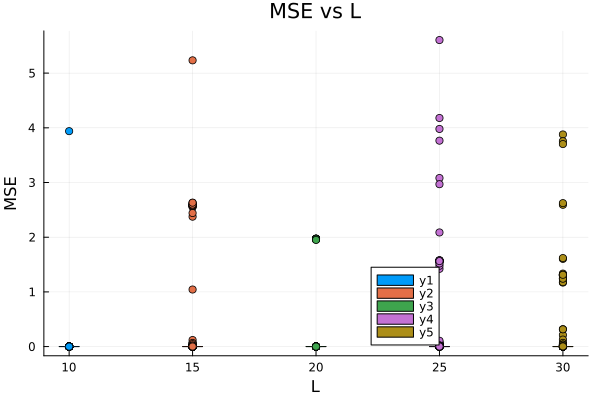

In [60]:
boxplot(config_master_L["L"], mse_master_L_rand[:, 1, 1, 4, :]', title="MSE vs L", xlabel="L", ylabel="MSE", legend=config_master_L["M"])

In [32]:
boxplot(Config_e0["L"], mse_master_D_rand[:, 1, 1, :], seriestype = :scatter, legend = false, xlabel = "L", ylabel = "MSE", title = "Level0: MSE vs L with global phase", yscale = :log10, xticks = Config_e0["L"])
# save plot
# savefig("e0_mse_vs_L_global_phase.png")

# boxplot(Vector(L)', mse_e0[:, 1, :]', seriestype = :scatter, legend = false, xlabel = "L", ylabel = "MSE", title = "Level0: MSE vs L with global phase (failures removed)", yscale = :log10, xticks = L, ylim=(1e-35, 1e-20))
# savefig("e0_mse_vs_L_global_phase_failures_removed.png")

UndefVarError: UndefVarError: mse_master_D_rand not defined

In [33]:

colorpalette = palette(:tab10, 10)

In [34]:
perturbs = LinRange(-1/4, 1/4, length(Config_e1["L"]))

boxplot(log10.(Config_e1["SE"]) .+ perturbs[1], mse_e1[1, :, 1, :]', seriestype = :scatter, label="L = $(Config_e1["L"][1])", bar_width=0.1, color = colorpalette[1])

for l = 2:length(Config_e1["L"])
    boxplot!(log10.(Config_e1["SE"]) .+ perturbs[l], mse_e1[l, :, 1, :]', seriestype = :scatter, legend = :topleft, xlabel = "Log SE", ylabel = "MSE", title = "Level1: MSE vs SE across different L", yscale = :log10, yticks = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0], label="L = $(Config_e1["L"][l])", xticks = [-5, -4, -3], bar_width=0.1, color = colorpalette[l])
    
end



savefig("e1_mse_vs_SE_global_phase.png")

UndefVarError: UndefVarError: mse_e1 not defined

In [35]:
mse_e2[1, 3, :, :]

UndefVarError: UndefVarError: mse_e2 not defined

In [36]:
boxplot(log10.(Config_e2["D"]), mse_e2_rand[1, 1, :, :]', seriestype = :scatter, legend = false, xlabel = "Log D", ylabel = "MSE", title = "Level2: MSE vs D with global phase", yscale = :log10, yticks = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0])

UndefVarError: UndefVarError: mse_e2_rand not defined

In [37]:
boxplot(Config_e2["L"], mse_e2_rand[:, 1, 1, :]', seriestype = :scatter, legend = false, xlabel = "L", ylabel = "MSE", title = "Level2: MSE vs L with global phase", yscale = :log10, yticks = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0])

UndefVarError: UndefVarError: mse_e2_rand not defined

241003
- M = 100K (50K, 100K, 150K, 200K)
- D --> 6 (1e-5 -> 1e-2?) 
- SE --> 6 (1e-5 -> 1e-2) have SE/D analyzed separately
- L = 10 (10-30 by 5s 10, 15, 20, 25, 30, x5)
- N = 500

Group 1:
-> SE scaling



Model errors additively
Error bar --> calculate variance / STD, and plot +/- sigma
guiding line for median, potentially percentiles?

--> How does it scale with D? SE? M? 


"What are the trends present?"

In [38]:
perturbs = LinRange(-1/4, 1/4, length(Config_e2["L"]))

boxplot(log10.(Config_e2["SE"]) .+ perturbs[1], mse_e2[1, :, 1, :]', seriestype = :scatter, label="L = $(Config_e2["L"][1])", bar_width=0.1, color = colorpalette[1])

for l = 2:length(Config_e2["L"])
    boxplot!(log10.(Config_e2["SE"]) .+ perturbs[l], mse_e2[l, :, 1, :]', seriestype = :scatter, legend = :topleft, xlabel = "Log SE", ylabel = "MSE", title = "Level2: MSE vs SE across different L", yscale = :log10, yticks = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0], label="L = $(Config_e2["L"][l])", xticks = [-5, -4, -3], bar_width=0.1, color = colorpalette[l])
    
end



savefig("e2_mse_vs_SE_global_phase.png")

UndefVarError: UndefVarError: mse_e2 not defined

In [39]:

l = @layout [a b c]
p1 = boxplot(Vector(L)', arccos_e1[:, 1, :]', yaxis =:log, label="1e-5" , xlabel="L", ylabel="arccos", xticks = ([10, 20, 30], ["10", "20", "30"]), yticks = ([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0], ["1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0"]), legend=:topleft)
p2 = boxplot(Vector(L)', arccos_e1[:, 2, :]', yaxis =:log, label="1e-4" , xlabel="L", ylabel="arccos", title="max arccos angle difference vs L and perturbation", xticks = ([10, 20, 30], ["10", "20", "30"]), yticks = ([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0], ["1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0"]), legend=:topleft)
p3 = boxplot(Vector(L)', arccos_e1[:, 3, :]', yaxis =:log, label="1e-3" , xlabel="L", ylabel="arccos", xticks = ([10, 20, 30], ["10", "20", "30"]), yticks = ([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0], ["1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0"]), legend=:topleft)

plot(p1, p2, p3, layout = l, link=:all, size=(1200, 400))

UndefVarError: UndefVarError: L not defined

In [40]:

l = @layout [a b c]
p1 = boxplot(Vector(L)', mse_e1[:, 1, :]', yaxis =:log, label="1e-5" , xlabel="L", ylabel="MSE", xticks = ([10, 20, 30], ["10", "20", "30"]), legend=:topleft, yticks = ([1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0], ["1e-11", "1e-10", "1e-9", "1e-8", "1e-7", "1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0"]))
p2 = boxplot(Vector(L)', mse_e1[:, 2, :]', yaxis =:log, label="1e-4" , xlabel="L", ylabel="MSE", title="MSE vs L and perturbation", xticks = ([10, 20, 30], ["10", "20", "30"]), legend=:topleft, yticks = ([1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0], ["1e-11", "1e-10", "1e-9", "1e-8", "1e-7", "1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0"]))
p3 = boxplot(Vector(L)', mse_e1[:, 3, :]', yaxis =:log, label="1e-3" , xlabel="L", ylabel="MSE", xticks = ([10, 20, 30], ["10", "20", "30"]),  legend=:topleft, yticks = ([1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0], ["1e-11", "1e-10", "1e-9", "1e-8", "1e-7", "1e-6", "1e-5", "1e-4", "1e-3", "1e-2", "1e-1", "1e0"]))

plot(p1, p2, p3, layout = l, link=:all, size=(1200, 400))

UndefVarError: UndefVarError: L not defined

In [41]:
# load file
# mse_e1_sin = nothing
# f = jldopen("20240927_211739_data_e1_sin", "r")
# mse_e1_sin = f["mse_e0"]

# jldopen("20240927_211739_data_e1_sin", "r") do file
#     mse_e1_sin = file["mse_e0"]
#     arccos_e1_sin = file["arccos_e0"]
# end
# histogram(mse_e1_sin[1, 1, :])

In [42]:
# Experiment 2:
# R = 2048 (for all)
L = [10, 20]
# M = N/A
N = 200
SE = [1e-5, 1e-4, 1e-3]
depolarizing = 1e-5

mse_e1_sin, arccos_e1_sin = run_experiment(L, SE, N, "e1_sin", global_phase=true, custom_phi_schedule=(L) -> [1/2 * sin(j / 2) for j = 1:L], depolarizing=depolarizing)

UndefVarError: UndefVarError: run_experiment not defined

In [43]:
# Experiment 2:
# R = 2048 (for all)
L = [10, 20]
# M = N/A
N = 200
SE = [1e-5, 1e-4, 1e-3]
depolarizing = 1e-4

mse_e1_sin_hd, arccos_e1_sin_hd = run_experiment(L, SE, N, "e1_sin", global_phase=true, custom_phi_schedule=(L) -> [1/2 * sin(j / 2) for j = 1:L], depolarizing=depolarizing)

UndefVarError: UndefVarError: run_experiment not defined


function find_magnitude(U; N=Inf)
    # Perform state tomography on 3 basis states: |0>, |+>, |i>
    alpha_ad, beta_cb_ad = single_qubit_state_tomography(U * Complex{BigFloat}[1; 0], N=N)
    alpha_ab, beta_cd_ab = single_qubit_state_tomography(H * U * H * Complex{BigFloat}[1; 0], N=N)
    
    # Make the |+i> state with an S gate
    alpha_ac, beta_bd_ac = single_qubit_state_tomography(H * S' * U * S * H * Complex{BigFloat}[1; 0], N=N)
    ABCD = postprocess_data(alpha_ab, alpha_ac, alpha_ad)
    @assert abs(ABCD[1]^2 + ABCD[2]^2 + ABCD[3]^2 + ABCD[4]^2 - 1) < 1e-4

    return ABCD, [beta_cb_ad, beta_cd_ab, beta_bd_ac]
end

In [44]:
# Experiment 2:
# R = 2048 (for all)
L = [10, 20]
# M = N/A
N = 200
SE = [1e-5, 1e-4, 1e-3]
depolarizing = 1e-3

mse_e1_sin_hd2, arccos_e1_sin_hd2 = run_experiment(L, SE, N, "e1_sin", global_phase=true, custom_phi_schedule=(L) -> [1/2 * sin(j / 2) for j = 1:L], depolarizing=depolarizing)

UndefVarError: UndefVarError: run_experiment not defined

In [45]:
boxplot([-5], mse_e1_sin[1, 1, :], seriestype = :scatter)

boxplot!([-4], mse_e1_sin_hd[1, 1, :], seriestype = :scatter)

boxplot!([-3], mse_e1_sin_hd2[1, 1, :], seriestype = :scatter, legend = false, xlabel = "Depolarizing", ylabel = "MSE", title = "Level2: MSE vs Depolarizing", yscale = :log10, xticks = [-5, -4, -3], yticks=[1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, ])

savefig("e1_sin_MSE_depolarizing.png")

# boxplot(, mse_e1_sin_hd[:, 1, :]', seriestype = :scatter, legend = false, xlabel = "L", ylabel = "MSE", title = "Level0: MSE vs L with global phase", yscale = :log10, xticks = L)


UndefVarError: UndefVarError: mse_e1_sin not defined

In [46]:
mse_e2_legendre[:, 1, 1, :]

UndefVarError: UndefVarError: mse_e2_legendre not defined

In [47]:
boxplot(Config_e2_legendre["L"], mse_e2_legendre[:, 1, 1, :]', seriestype = :scatter, legend = false, xlabel = "L", ylabel = "MSE", title = "Level2: MSE vs L with global phase", yscale = :log10, xticks = Config_e2_legendre["L"])

UndefVarError: UndefVarError: mse_e2_legendre not defined